<a href="https://colab.research.google.com/github/devil-of-silicon-valley/cmpe255-project/blob/main/Project_Group_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group 5:  Reuter_50_50 Data Set (https://archive.ics.uci.edu/ml/datasets/Reuter_50_50Links to an external site.)

Identify the author of an article based on attributes describing their writing style

This notebook is a consolidation of all the previous notebooks to the final approach that was used.

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Import necessary libraries and make auxilliary functions

In [43]:
import os
import json
from glob import glob
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from scipy.sparse import csr_matrix as sp_csr_matrix

In [44]:
def load_json(json_file):
  with open(json_file) as f:
    data = json.load(f)
  return data

def write_json(json_file, data):
  with open(json_file, "w") as outfile:
    json.dump(data, outfile)

## Step 2: Initial Dataset Construction

Refer to **Initial Dataset Construction** in [Project_Baseline_Shabab.ipynb](https://github.com/devil-of-silicon-valley/cmpe255-project/blob/main/Baseline/Program_Baseline_Shabab.ipynb) for more information on how the initial raw dataset was processed to construct the JSONs used for faster pre-processing.

The following code was used to generate the JSONs.

In [49]:
# get the train and set directories
train_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50train'
test_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50test'

In [50]:
# create a function to load the data from the directories
def parse_raw_data(dir, json_save_dir, debug=False):

  print(f"Creating JSON from data in {dir}")

  # initialize empty dictionary to fill with author information
  data_dict = {}

  # get the list of author directories
  author_dirs = sorted(glob(f"{dir}/*"))
  print(f"Found {len(author_dirs)} authors...")

  # now parse the directories for the author names and their associated texts
  for author_dir in author_dirs:

    # get the author name from the directory
    author_name = author_dir.split('/')[-1]

    if debug: print(f"Loading files for {author_name}")

    total_files = len(glob(f"{author_dir}/*.txt"))
    if debug: print(f"Found {total_files} files for {author_name}")

    author_file_entry = {}
    for file_entry in sorted(glob(f"{author_dir}/*.txt")):
      # get te filename (ex: 2537newsML.txt)
      author_filename = file_entry.split('/')[-1]
      # Read the file and remove any new lines or raw strings
      author_file = open(file_entry, "r").read().replace('\n', '').replace('\r', '')
      # create the dictionary accordingly
      author_file_entry[author_filename] = author_file
      # example of an entry "Author1" : {"1234text.txt" : "Text for this entry"}

    if debug: print(f"Adding {author_name} to data dictionary")

    # add the dictionary entry for the current author and their files
    data_dict[author_name] = author_file_entry

  write_json(json_save_dir, data_dict)

  return data_dict

In [ ]:
train_json_path = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50train.json'
test_json_path = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50test.json'
train_json = parse_raw_data(dir=train_dir, json_save_dir=train_json_path)
test_json = parse_raw_data(dir=test_dir, json_save_dir=test_json_path)

Output from Program_Baseline_Shabab.ipynb that generated the resulting JSONs

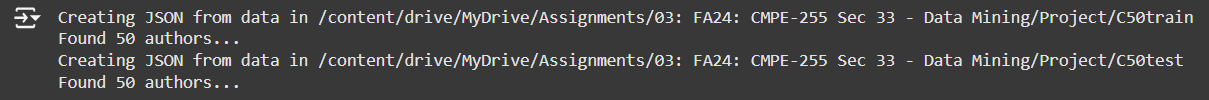

## Step 3: Refactoring Data for Pre-Processing

In [54]:
# this function will refactor the data dictionary to a format
# that is more friendly for dataframes
def refactor_data(data_dict):
  # create the dictionary that will be converted to a dataframe
  refactored_data_dict = {}
  # init list of unique authors
  authors = []
  # init raw labels (authors) and data (text)
  # that will be used for actual training
  labels = []
  data = []
  # parse the dictionary to get the files for each author
  for author_entry, file_entry in data_dict.items():
    # init the text list for each author
    text_list = []
    # add the current author to the list of total authors
    authors.append(author_entry)
    # parse the text list to add to the relevant lists
    for file_name, file_text in file_entry.items():
      labels.append(author_entry)
      data.append(file_text)
    refactored_data_dict[author_entry] = data
  data_df = pd.DataFrame(refactored_data_dict, index=None).T
  return data_df, authors, labels, data

In [47]:
# read the jsons
train_json_path = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50train.json'
test_json_path = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50test.json'

train_json = load_json(train_json_path)
test_json = load_json(test_json_path)

# this function will refactor the data dictionary to a format
# that is more friendly for dataframes
def refactor_data(data_dict):

  # create the dictionary that will be converted to a dataframe
  refactored_data_dict = {}

  # init list of unique authors
  authors = []

  # init raw labels (authors) and data (text)
  # that will be used for actual training
  labels = []
  data = []

  # parse the dictionary to get the files for each author
  for author_entry, file_entry in data_dict.items():

    # init the text list for each author
    text_list = []

    # add the current author to the list of total authors
    authors.append(author_entry)

    # parse the text list to add to the relevant lists
    for file_name, file_text in file_entry.items():
      labels.append(author_entry)
      data.append(file_text)

    refactored_data_dict[author_entry] = data

  data_df = pd.DataFrame(refactored_data_dict, index=None).T
  return data_df, authors, np.array(labels), np.array(data)

train_data_df, train_authors, train_labels, train_data = refactor_data(train_json)
test_data_df, test_authors, test_labels, test_data = refactor_data(test_json)

Let's preview the training data as a DataFrame

In [48]:
train_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
AaronPressman,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,China has taken its cue from U.S. Federal Rese...,"The Stone Group, a Chinese high technology com...",China said on Thursday it strongly opposed a v...,A top Chinese defence official has stepped dow...,China warned on Monday against reinforcing mil...,China's central bank chief has said that infla...,"China ushered in 1997, a year it has hailed as...",China issued tough new rules on the handling o...,China will avoid bold moves in tackling its ai...,Communist Party chief Jiang Zemin has put his ...
AlanCrosby,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,China has taken its cue from U.S. Federal Rese...,"The Stone Group, a Chinese high technology com...",China said on Thursday it strongly opposed a v...,A top Chinese defence official has stepped dow...,China warned on Monday against reinforcing mil...,China's central bank chief has said that infla...,"China ushered in 1997, a year it has hailed as...",China issued tough new rules on the handling o...,China will avoid bold moves in tackling its ai...,Communist Party chief Jiang Zemin has put his ...
AlexanderSmith,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,China has taken its cue from U.S. Federal Rese...,"The Stone Group, a Chinese high technology com...",China said on Thursday it strongly opposed a v...,A top Chinese defence official has stepped dow...,China warned on Monday against reinforcing mil...,China's central bank chief has said that infla...,"China ushered in 1997, a year it has hailed as...",China issued tough new rules on the handling o...,China will avoid bold moves in tackling its ai...,Communist Party chief Jiang Zemin has put his ...
BenjaminKangLim,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,China has taken its cue from U.S. Federal Rese...,"The Stone Group, a Chinese high technology com...",China said on Thursday it strongly opposed a v...,A top Chinese defence official has stepped dow...,China warned on Monday against reinforcing mil...,China's central bank chief has said that infla...,"China ushered in 1997, a year it has h

## Step 4: Vectorize/Transform the Data

In [52]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Limit to the top 10,000 features for performance
    stop_words='english',  # Remove common English stopwords
    lowercase=True,  # Convert text to lowercase
    )

# Transform text data into TF-IDF feature vectors
X = tfidf_vectorizer.fit_transform(train_data)
y = np.array(train_labels)

print(f"TF-IDF Feature Shape: {X.shape}")

TF-IDF Feature Shape: (2500, 10000)


## Step 5: Train-Split Data

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Set Shape: {X_train.shape}, Test Set Shape: {X_test.shape}")

Train Set Shape: (2000, 10000), Test Set Shape: (500, 10000)


## Step 6: Dimensionality Reduction + Hyperparameter Tuning

In [55]:
# Dimensionality Reduction with Truncated SVD
svd = TruncatedSVD(n_components=1750, random_state=42)

# Normalize the data
normalizer = Normalizer(norm='l2',copy=False)

In [56]:
# Initialize Logistic Regression model
logreg = LogisticRegression(random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None,'balanced'],
    'max_iter': [500, 1000],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    logreg,
    param_grid,
    scoring='f1_weighted',  # Use F1-weighted as scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=1  # Display progress
)

grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Classification Report:
                   precision    recall  f1-score   support

    AaronPressman       0.71      0.83      0.77         6
       AlanCrosby       1.00      1.00      1.00        10
   AlexanderSmith       0.86      0.86      0.86         7
  BenjaminKangLim       0.64      0.64      0.64        11
    BernardHickey       1.00      0.71      0.83        14
      BradDorfman       0.67      0.91      0.77        11
 DarrenSchuettler       0.83      1.00      0.91         5
      DavidLawder       0.86      1.00      0.92         6
    EdnaFernandes       0.85      0.69      0.76        16
      EricAuchard       0.86      0.86      0.86        14
   FumikoFujisaki       0.91      1.00      0.95        10
   GrahamEarnshaw       1.00      1.00      1.00         8
 HeatherScoffield       0.90      0.82      0.86        11
       JanLopatka       0.88      0.70      0.78        10
    JaneMacartney       0.50 

## Step 6: Logistic Regression

In [57]:
pipeline = Pipeline([
    ('svd', svd),
    ('classifier', LogisticRegression(C=100, class_weight='balanced', max_iter=1000,random_state=42)),
    ])

# Train the Model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('svd', TruncatedSVD(n_components=1750, random_state=42)),
                ('classifier',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, random_state=42))])

## Step 7: F1 Score + Classification Report

In [58]:
# Evaluate the Model
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                   precision    recall  f1-score   support

    AaronPressman       0.71      0.83      0.77         6
       AlanCrosby       1.00      1.00      1.00        10
   AlexanderSmith       0.86      0.86      0.86         7
  BenjaminKangLim       0.64      0.64      0.64        11
    BernardHickey       1.00      0.71      0.83        14
      BradDorfman       0.67      0.91      0.77        11
 DarrenSchuettler       0.83      1.00      0.91         5
      DavidLawder       0.86      1.00      0.92         6
    EdnaFernandes       0.85      0.69      0.76        16
      EricAuchard       0.86      0.86      0.86        14
   FumikoFujisaki       0.91      1.00      0.95        10
   GrahamEarnshaw       1.00      1.00      1.00         8
 HeatherScoffield       0.90      0.82      0.86        11
       JanLopatka       0.88      0.70      0.78        10
    JaneMacartney       0.50      1.00      0.67         5
     JimGilchrist       0.89    

In [59]:
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Weighted F1 Score: {f1:.4f}")

Weighted F1 Score: 0.8460


## Step 8: Predict on C50Test

In [60]:
# Transform Test Data into TF-IDF Features
X_test_new = tfidf_vectorizer.transform(test_data)  # Use the trained vectorizer on test data
y_test_new = np.array(test_labels)

print(f"Transformed Test Feature Shape: {X_test_new.shape}")

Transformed Test Feature Shape: (2500, 10000)


In [61]:
y_pred_new = pipeline.predict(X_test_new)

print("Classification Report on Test Data:")
print(classification_report(y_test_new, y_pred_new))

# Optional: Calculate Weighted F1 Score
f1_new = f1_score(y_test_new, y_pred_new, average='macro')
print(f"Weighted F1 Score on Test Data: {f1_new:.4f}")

Classification Report on Test Data:
                   precision    recall  f1-score   support

    AaronPressman       0.86      0.96      0.91        50
       AlanCrosby       0.90      0.52      0.66        50
   AlexanderSmith       0.50      0.32      0.39        50
  BenjaminKangLim       0.37      0.22      0.28        50
    BernardHickey       0.83      0.50      0.62        50
      BradDorfman       0.62      0.96      0.75        50
 DarrenSchuettler       0.37      0.28      0.32        50
      DavidLawder       0.69      0.50      0.58        50
    EdnaFernandes       0.92      0.44      0.59        50
      EricAuchard       0.47      0.56      0.51        50
   FumikoFujisaki       0.98      1.00      0.99        50
   GrahamEarnshaw       0.75      0.88      0.81        50
 HeatherScoffield       0.32      0.38      0.35        50
       JanLopatka       0.62      0.46      0.53        50
    JaneMacartney       0.35      0.34      0.34        50
     JimGilchrist  

SVD:

accuracy                           0.62      2500
Weighted F1 Score on Test Data:

w/ GridSearch best_model:

accuracy                           0.66      2500
Weighted F1 Score on Test Data: 0.6539

PCA:

accuracy                           0.61      2500
Weighted F1 Score on Test Data: 0.6059

w/ GridSearch best_model:

accuracy                           0.66      2500
Weighted F1 Score on Test Data: 0.6591